# Benchmark with Cell2Location
</div>

Input: 
- Reference: `CID44971` scRNA-seq dataset
(https://www.nature.com/articles/s41588-021-00911-1)
- Target: `CID44971` ST dataset

### Loading packages

In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    !pip install --quiet scvi-colab
    from scvi_colab import install
    install()
    !pip install --quiet git+https://github.com/BayraktarLab/cell2location#egg=cell2location[tutorials]

In [2]:
import os
import skimage.io as io
import json

import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl

import cell2location
import scvi

from scipy.io import mmread
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text for PDFs

/home/yinuo/anaconda3/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.16) or chardet (5.1.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
Global seed set to 0
/home/yinuo/.local/lib/python3.8/site-packages/chex/_src/pytypes.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))
/home/yinuo/.local/lib/python3.8/site-packages/flax/struct.py:144: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/yinuo/.local/lib/python3.8/site-packages/flax/struct.py:144: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a fu

In [3]:
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib import rcParams

import seaborn as sns
sns.set_style('white')

font_list = []
fpaths = matplotlib.font_manager.findSystemFonts()
for i in fpaths:
    try:
        f = matplotlib.font_manager.get_font(i)
        font_list.append(f.family_name)
    except RuntimeError:
        pass

font_list = set(font_list)
plot_font = 'Helvetica' if 'Helvetica' in font_list else 'FreeSans'

rcParams['font.family'] = plot_font
rcParams.update({'font.size': 10})
rcParams.update({'figure.dpi': 300})
rcParams.update({'figure.figsize': (3,3)})
rcParams.update({'savefig.dpi': 500})

import warnings
warnings.filterwarnings('ignore')

In [4]:
import utils as benchmark_utils

### I. Simulation

#### (1). Major cell-type simulation (`simu_5`)

**Load data**

In [5]:
data_path = '../data/'
sample_id = 'simu_5'

adata_vis = sc.AnnData(pd.read_csv(os.path.join(data_path, sample_id, 'counts.st_synth.csv'), index_col=0))

# find mitochondria-encoded (MT) genes
adata_vis.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_vis.var.index]

# remove MT genes for spatial mapping (keeping their counts in the object)
adata_vis.obsm['MT'] = adata_vis[:, adata_vis.var['MT_gene'].values].X.toarray()
adata_vis = adata_vis[:, ~adata_vis.var['MT_gene'].values]

In [6]:
# Load ground-truth proportion & densities
mem_df = pd.read_csv(os.path.join(data_path, sample_id, 'members.st_synth.csv'),index_col=0)
prop_df = pd.read_csv(os.path.join(data_path, sample_id, 'proportions.st_synth.csv'),index_col=0)

In [7]:
# Get Cell2Location subset-level annotations from available cell types in ground-truth
major_dict = {
    'CAFs': 'CAFs',
    'Cancer Epithelial': 'Cancer_Epithelial',
    'Myeloid': 'Myeloid',
    'Normal Epithelial': 'Normal_Epithelial',
    'T-cells': 'T-cells'
}

In [8]:
# Load paired scRNA-seq data
sc_path = '../../starfysh/data/CID44971_TNBC/scrna/'

barcode_df = pd.read_csv(
    os.path.join(sc_path, 'count_matrix_barcodes.tsv'), 
    delimiter='\t',
    header=None # this file doesn't contain the true "header" (column info), the first row is a TRUE barcode
)

gene_df = pd.read_csv(
    os.path.join(sc_path, 'count_matrix_genes.tsv'),
    delimiter='\t',
    header=None # this file doesn't contain the true "header" (column info), the first row is a TRUE gene
)

barcodes = pd.DataFrame(barcode_df[0].values, index=barcode_df[0].values, columns=['Barcode'])
genes = pd.DataFrame(gene_df[0].values, index=gene_df[0].values, columns=['features'])

cnt = mmread(
    os.path.join(sc_path, 'count_matrix_sparse.mtx')
).toarray()

adata_sc = sc.AnnData(
    X=cnt.T,
    obs=barcodes,
    var=genes
)

In [9]:
# Rename annotations & only keep scRNA-seq index with cell types existing in the synthetic ST data
meta_df = pd.read_csv(
    os.path.join(sc_path, 'metadata.csv'), index_col=[0], header=[0]
)
annots = meta_df['celltype_major'].apply(lambda x: major_dict[x] if x in major_dict.keys() else np.nan)

cells_to_keep = annots.isin(prop_df.columns)
adata_sc = adata_sc[cells_to_keep, :]
annots = annots[cells_to_keep]
adata_sc.obs['major_cell_types'] = annots[cells_to_keep].tolist()

adata_sc

AnnData object with n_obs × n_vars = 7261 × 29733
    obs: 'Barcode', 'major_cell_types'
    var: 'features'

**Running Cell2Location**

Filtering low-quality cells

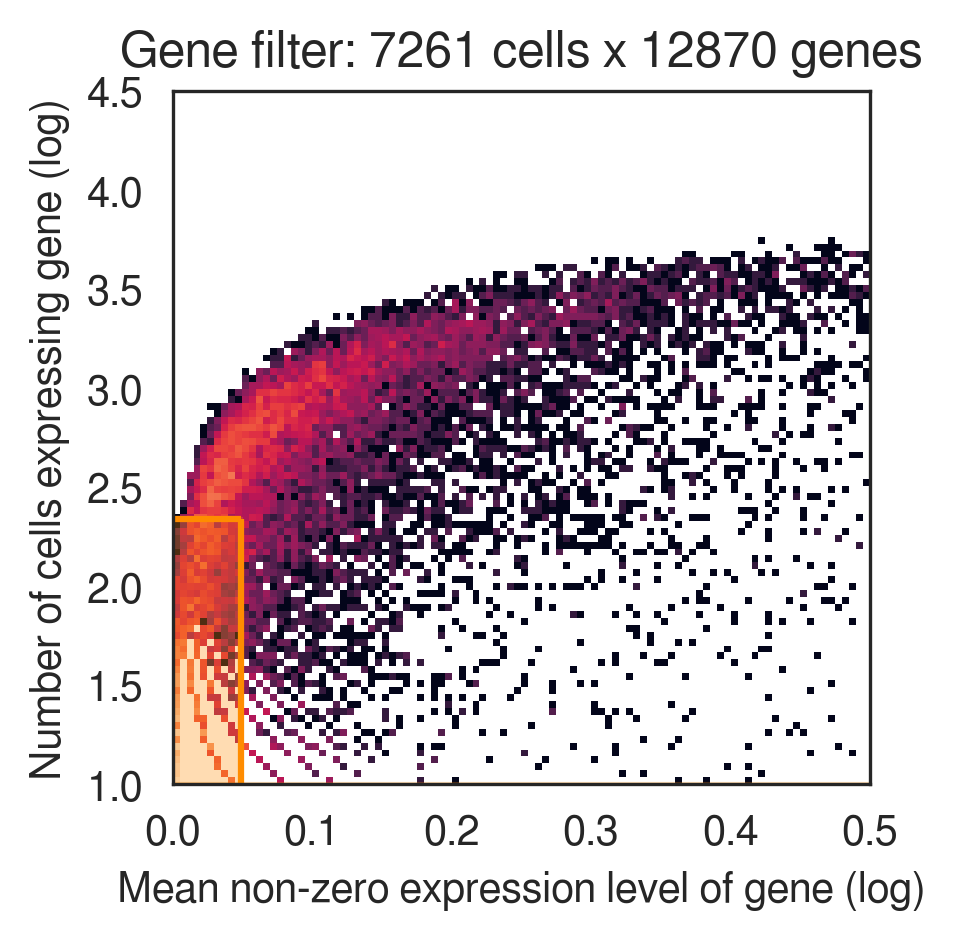

In [10]:
from cell2location.utils.filtering import filter_genes

selected = filter_genes(adata_sc, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

# filter the object
adata_sc = adata_sc[:, selected].copy()

**Estimation of reference cell type signatures**

In [11]:
# prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata=adata_sc, labels_key='major_cell_types')

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [12]:
# create the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(adata_sc)

# view anndata_setup as a sanity check
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.20.3.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': None,
│   'labels_key': 'major_cell_types',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 7261  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   5   │
│          n_vars          │ 12870 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                           labels State Registry                           
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃        Source Location        ┃    Categories     ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['major_cell_types'] │       CAFs        │          0          │
│                               │ Cancer_Epithelial │          1          │
│                               │      Myeloid      │          2          │
│                               │ Normal_Epithelial │          3          │
│                               │      T-cells      │          4          │
└───────────────────────────────┴───────────────────┴─────────────────────┘

In [13]:
mod.train(max_epochs=1000, use_gpu=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1000/1000: 100%|████████████████████████████████████████████████████████████████| 1000/1000 [04:57<00:00,  3.36it/s, v_num=1, elbo_train=4.19e+7]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 1000/1000: 100%|████████████████████████████████████████████████████████████████| 1000/1000 [04:57<00:00,  3.36it/s, v_num=1, elbo_train=4.19e+7]


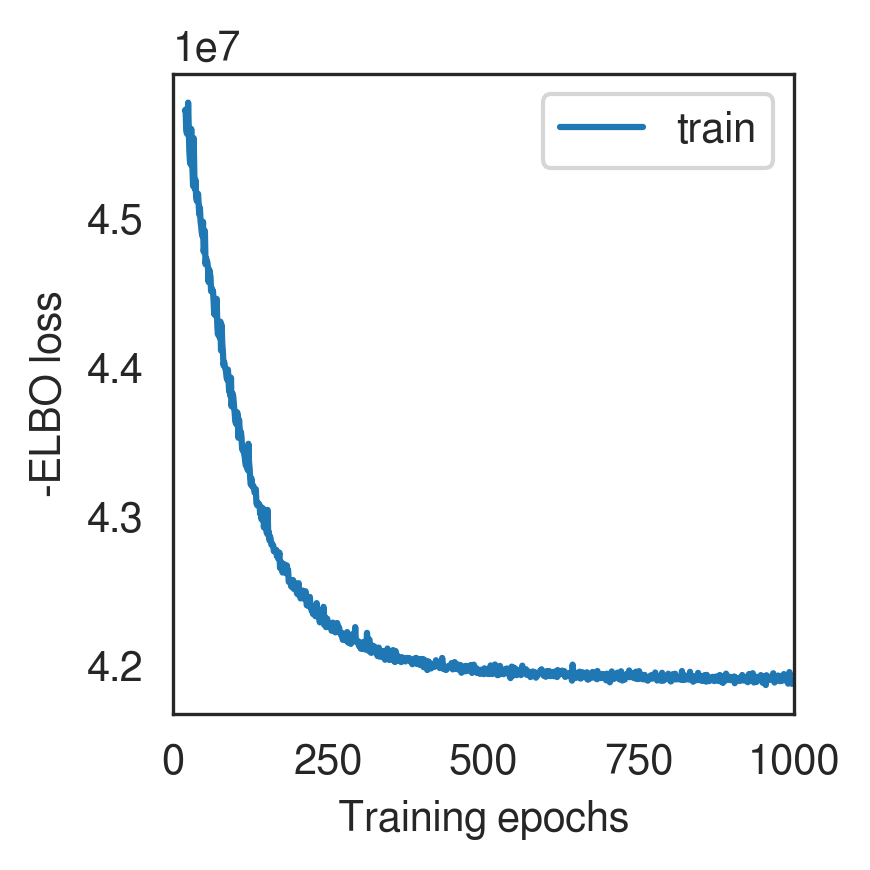

In [15]:
mod.plot_history(20)

Extract estimated expressions of signatures in each cell type:

In [16]:
# Sample posterior estimates
adata_sc = mod.export_posterior(
    adata_sc, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
)

# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_sc.varm.keys():
    inf_aver = adata_sc.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_sc.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_sc.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_sc.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_sc.uns['mod']['factor_names']
inf_aver.head()

Sampling global variables, sample: 100%|████████████████████████████████████████████████████████████████████████████| 999/999 [00:08<00:00, 117.91it/s]


,CAFs,Cancer_Epithelial,Myeloid,Normal_Epithelial,T-cells
FO538757.2,0.101299,0.352218,0.243159,0.215410,0.053671
NOC2L,0.217577,1.794309,0.296311,0.744707,0.161908
HES4,0.320783,3.556160,0.118908,1.353176,0.008717
ISG15,1.011187,0.587743,3.456648,0.349180,0.801957
AGRN,0.049559,0.173026,0.032081,0.298945,0.002066


**Cell2Location mapping & deconvolution**

In [17]:
# Subset shared genes between scRNA-seq ref & ST data
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis)

In [18]:
# Create & train the model
mod = cell2location.models.Cell2location(
    adata_vis, 
    cell_state_df=inf_aver,
     N_cells_per_location=10,
    detection_alpha=200
)

In [ ]:
mod.train(max_epochs=10000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu=True,
         )

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1919/10000:  19%|███████████▉                                                  | 1918/10000 [02:37<11:12, 12.03it/s, v_num=1, elbo_train=3.34e+7]

Exporting estimated posterior distributions of cell abundance and save results:

In [ ]:
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
)

In [ ]:
# Convert density to proportions, calculate accuracy with GT & save results to output
density = adata_vis.obsm['q05_cell_abundance_w_sf']
proportions_cell2loc_df = density.div(density.sum(1), axis=0)
proportions_cell2loc_df.columns = [
    label.split('_w_sf_')[-1]
    for label in proportions_cell2loc_df.columns
]

proportions_cell2loc_df.head()

In [ ]:
out_path = 'results/'
proportions_cell2loc_df.to_csv(
    os.path.join(out_path, 'Cell2Location_proportion_simu_5.csv'),
    index=True
)

Load previously saved proportions:

In [ ]:
# out_path = 'results/'
# proportions_cell2loc_df = pd.read_csv(os.path.join(out_path, 'Cell2Location_proportion_simu_5.csv'), index_col=0)

Benchmark plots:

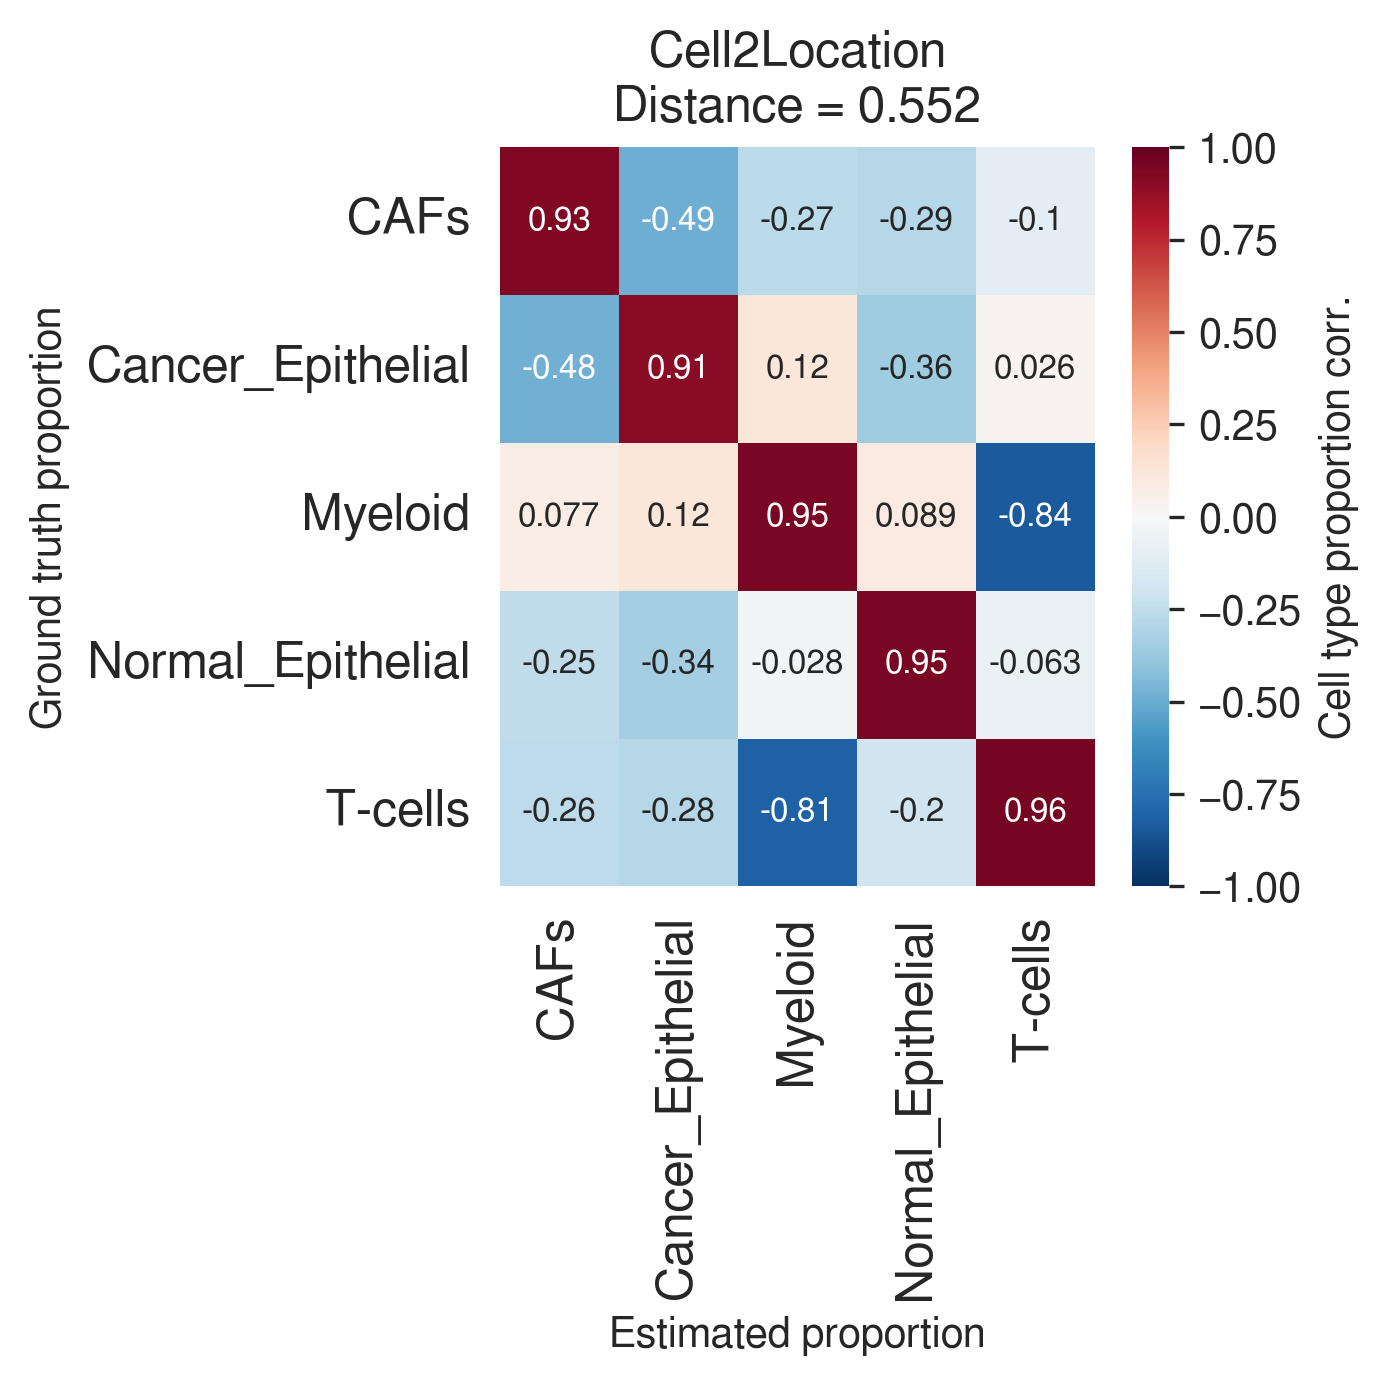

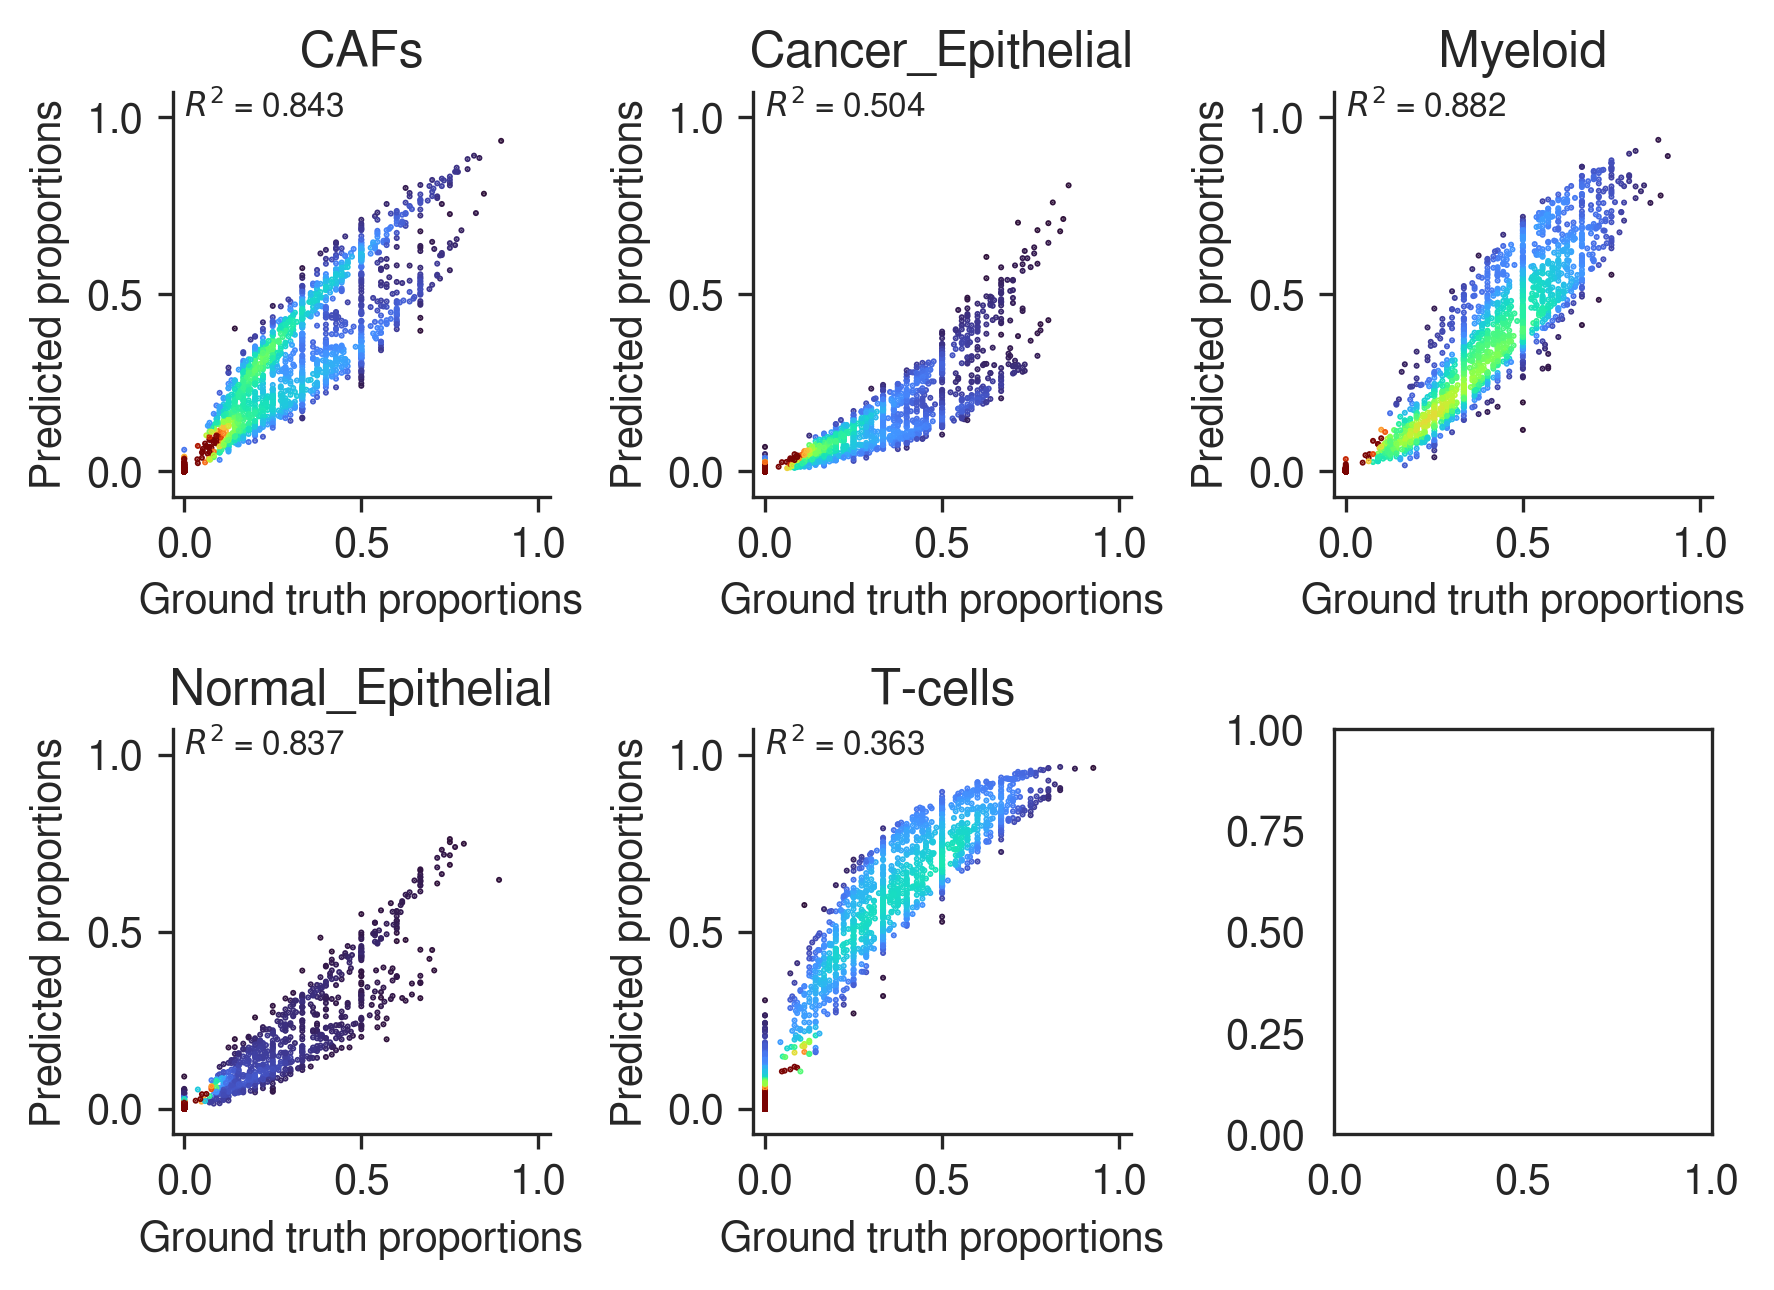

In [25]:
out_path = '../../plot_files/starfysh_revision/'

benchmark_utils.disp_corr(prop_df, proportions_cell2loc_df,
          fontsize=8,
          title='Cell2Location',
          outdir=out_path,
          filename='simu_5_cell2loc_heatmap',
          savefig=True
)

benchmark_utils.disp_prop_scatter(prop_df, proportions_cell2loc_df,
                  outdir=out_path,
                  filename='simu_5_cell2loc_scatter',
                  %noteboo
                  savefig=True
)

#### (2). Fine-grained cell-type simulation (`simu_10`)

**Load data**

In [3]:
# Load ST data
data_path = '../data/'
sample_id = 'simu_10'

adata_vis = sc.AnnData(pd.read_csv(os.path.join(data_path, sample_id, 'counts.st_synth.csv'), index_col=0))

# find mitochondria-encoded (MT) genes
adata_vis.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_vis.var.index]

# remove MT genes for spatial mapping (keeping their counts in the object)
adata_vis.obsm['MT'] = adata_vis[:, adata_vis.var['MT_gene'].values].X.toarray()
adata_vis = adata_vis[:, ~adata_vis.var['MT_gene'].values]

/tmp/ipykernel_76563/1903172393.py:5: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_vis = sc.AnnData(pd.read_csv(os.path.join(data_path, sample_id, 'counts.st_synth.csv'), index_col=0))


In [4]:
# Load ground-truth proportion & densities
mem_df = pd.read_csv(os.path.join(data_path, sample_id, 'members.st_synth.csv'),index_col=0)
prop_df = pd.read_csv(os.path.join(data_path, sample_id, 'proportions.st_synth.csv'),index_col=0)

In [1]:
# Get Cell2Location subset-level annotations from available cell types in ground-truth
subset_dict = {
    'Cancer Basal SC':                  'Basal',
    'Cancer LumB SC':                   'LumB',
    'Myoepithelial':                    'Normal epithelial',
    'T_cells_c0_CD4+_CCR7':             'Tcm',
    'T_cells_c1_CD4+_IL7R':             'Tem',
    'T_cells_c3_CD4+_Tfh_CXCL13':       'Tfh',
    'T_cells_c2_CD4+_T-regs_FOXP3':     'Treg',
    'T_cells_c7_CD8+_IFNG':             'Activated CD8',
    'T_cells_c8_CD8+_LAG3':             'Terminal exhaustion',
    'B cells Memory':                   'B cells memory',
    'B cells Naive':                    'B cells naive',
    'Myeloid_c10_Macrophage_1_EGR1':    'Macrophage M1',
    'Myeloid_c9_Macrophage_2_CXCL10':   'Macrophage M2',
    'Plasmablasts':                     'Plasmablasts',
    'Myeloid_c7_Monocyte_3_FCGR3A':     'Monocytes',
    'Myeloid_c12_Monocyte_1_IL1B':      'Monocytes',
    'Myeloid_c8_Monocyte_2_S100A9':     'Monocytes',
    'Myeloid_c11_cDC2_CD1C':            'cDC',
    'Myeloid_c3_cDC1_CLEC9A':           'cDC',
    'Myeloid_c4_DCs_pDC_IRF7':          'pDC',
    'CAFs MSC iCAF-like s1':            'CAFs MSC iCAF-like',
    'CAFs MSC iCAF-like s2':            'CAFs MSC iCAF-like',
    'CAFs myCAF like s4':               'CAFs myCAF-like',
    'CAFs myCAF like s5':               'CAFs myCAF-like',
    'PVL Immature s1':                  'PVL immature',
    'PVL_Immature s2':                  'PVL immature',
    'PVL Differentiated s3':            'PVL differentiated',
    'Endothelial ACKR1':                'Endothelial',
    'Endothelial CXCL12':               'Endothelial',
    'Endothelial Lymphatic LYVE1':      'Endothelial',
    'Endothelial RGS5':                 'Endothelial'
}

In [5]:
np.unique(list(subset_dict.values()))

array(['Activated CD8', 'B cells memory', 'B cells naive', 'Basal',
       'CAFs MSC iCAF-like', 'CAFs myCAF-like', 'Endothelial', 'LumB',
       'Macrophage M1', 'Macrophage M2', 'Monocytes', 'Normal epithelial',
       'PVL differentiated', 'PVL immature', 'Plasmablasts', 'Tcm', 'Tem',
       'Terminal exhaustion', 'Tfh', 'Treg', 'cDC', 'pDC'], dtype='<U19')

In [28]:
# Load paired scRNA-seq data
sc_path = '../../starfysh/data/CID44971_TNBC/scrna/'

barcode_df = pd.read_csv(
    os.path.join(sc_path, 'count_matrix_barcodes.tsv'), 
    delimiter='\t',
    header=None # this file doesn't contain the true "header" (column info), the first row is a TRUE barcode
)

gene_df = pd.read_csv(
    os.path.join(sc_path, 'count_matrix_genes.tsv'),
    delimiter='\t',
    header=None # this file doesn't contain the true "header" (column info), the first row is a TRUE gene
)

barcodes = pd.DataFrame(barcode_df[0].values, index=barcode_df[0].values, columns=['Barcode'])
genes = pd.DataFrame(gene_df[0].values, index=gene_df[0].values, columns=['features'])

cnt = mmread(
    os.path.join(sc_path, 'count_matrix_sparse.mtx')
).toarray()

adata_sc = sc.AnnData(
    X=cnt.T,
    obs=barcodes,
    var=genes
)

/tmp/ipykernel_76563/3606600177.py:23: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_sc = sc.AnnData(


In [29]:
# Rename annotations & only keep scRNA-seq index with 10 cell types existing in the synthetic ST data
meta_df = pd.read_csv(
    os.path.join(sc_path, 'metadata.csv'), index_col=[0], header=[0]
)
annots = meta_df['celltype_subset'].apply(lambda x: subset_dict[x] if x in subset_dict.keys() else np.nan)

cells_to_keep = annots.isin(prop_df.columns)
adata_sc = adata_sc[cells_to_keep, :]
annots = annots[cells_to_keep]
adata_sc.obs['subset_cell_types'] = annots[cells_to_keep].tolist()

adata_sc

/tmp/ipykernel_76563/3394716409.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_sc.obs['subset_cell_types'] = annots[cells_to_keep].tolist()


AnnData object with n_obs × n_vars = 3901 × 29733
    obs: 'Barcode', 'subset_cell_types'
    var: 'features'

**Running Cell2Location**

Filter low-quality genes:

/home/yinuo/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


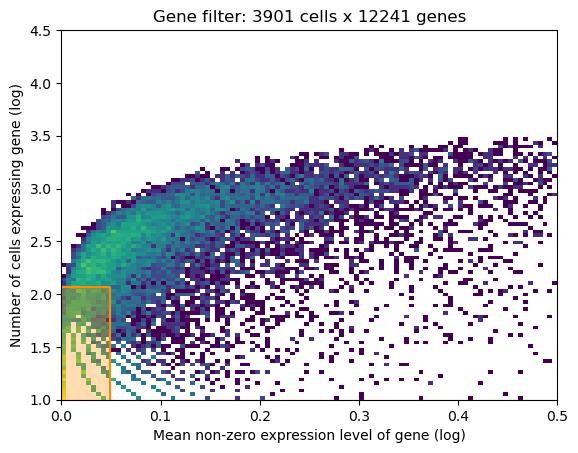

In [30]:
from cell2location.utils.filtering import filter_genes

selected = filter_genes(adata_sc, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

# filter the object
adata_sc = adata_sc[:, selected].copy()

**Estimation of reference cell type signatures**

In [32]:
# prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata=adata_sc, labels_key='subset_cell_types')

In [33]:
# create the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(adata_sc)

# view anndata_setup as a sanity check
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.20.3.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': None,
│   'labels_key': 'subset_cell_types',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 3901  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │  10   │
│          n_vars          │ 12241 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                            labels State Registry                            
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃        Source Location         ┃     Categories     ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['subset_cell_types'] │   Activated CD8    │          0          │
│                                │   B cells memory   │          1          │
│                                │       Basal        │          2          │
│                                │ CAFs MSC iCAF-like │          3          │
│                                │  CAFs myCAF-like   │          4          │
│                                │    Endothelial     │          5          │
│                                │    PVL immature    │          6          │
│                                │        Tcm         │          7          │
│                                │        Treg        │          8          │
│                                │        pDC         │          9          │
└────────────────────────────────┴────────────────────┴─────────────────────┘

In [34]:
mod.train(max_epochs=1000, use_gpu=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/yinuo/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:106: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/yinuo/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 1000/1000: 100%|███████████████████████████| 1000/1000 [02:43<00:00,  6.11it/s, v_num=1, elbo_train=2.12e+7]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 1000/1000: 100%|███████████████████████████| 1000/1000 [02:43<00:00,  6.13it/s, v_num=1, elbo_train=2.12e+7]


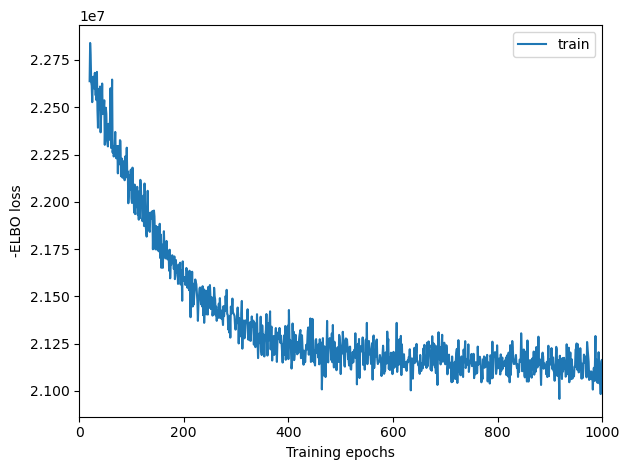

In [35]:
mod.plot_history(20)

Extract estimated expressions of signatures in each cell type:

In [36]:
# Sample posterior estimates
adata_sc = mod.export_posterior(
    adata_sc, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
)

# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_sc.varm.keys():
    inf_aver = adata_sc.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_sc.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_sc.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_sc.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_sc.uns['mod']['factor_names']
inf_aver.head()

Sampling global variables, sample: 100%|███████████████████████████████████████| 999/999 [00:08<00:00, 118.46it/s]


,Activated CD8,B cells memory,Basal,CAFs MSC iCAF-like,CAFs myCAF-like,Endothelial,PVL immature,Tcm,Treg,pDC
FO538757.2,0.080879,0.048296,0.373471,0.103459,0.130975,0.108921,0.066116,0.050115,0.080547,0.122926
RP11-206L10.9,0.004766,0.010713,0.177951,0.010981,0.069336,0.018516,0.038489,0.003029,0.007584,0.030656
NOC2L,0.164227,0.200704,1.829495,0.220033,0.293417,0.262160,0.243655,0.152951,0.173631,0.327341
HES4,0.006640,0.003546,3.239623,0.118378,1.035076,0.284811,1.527389,0.008839,0.007395,0.045363
ISG15,0.660945,0.747243,0.697461,0.443040,2.916617,1.546037,1.657257,0.350286,1.055454,1.847651


**Cell2Location mapping & deconvolution**


In [42]:
import time

In [37]:
# Subset shared genes between scRNA-seq ref & ST data
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis)

In [41]:
# Create & train the model
mod = cell2location.models.Cell2location(
    adata_vis, 
    cell_state_df=inf_aver,
     N_cells_per_location=10,
    detection_alpha=200
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 10000/10000: 100%|███████████████████████████████████████████████████████████| 10000/10000 [12:27<00:00, 11.93it/s, v_num=1, elbo_train=9.86e+6]

`Trainer.fit` stopped: `max_epochs=10000` reached.


Epoch 10000/10000: 100%|███████████████████████████████████████████████████████████| 10000/10000 [12:27<00:00, 13.38it/s, v_num=1, elbo_train=9.86e+6]


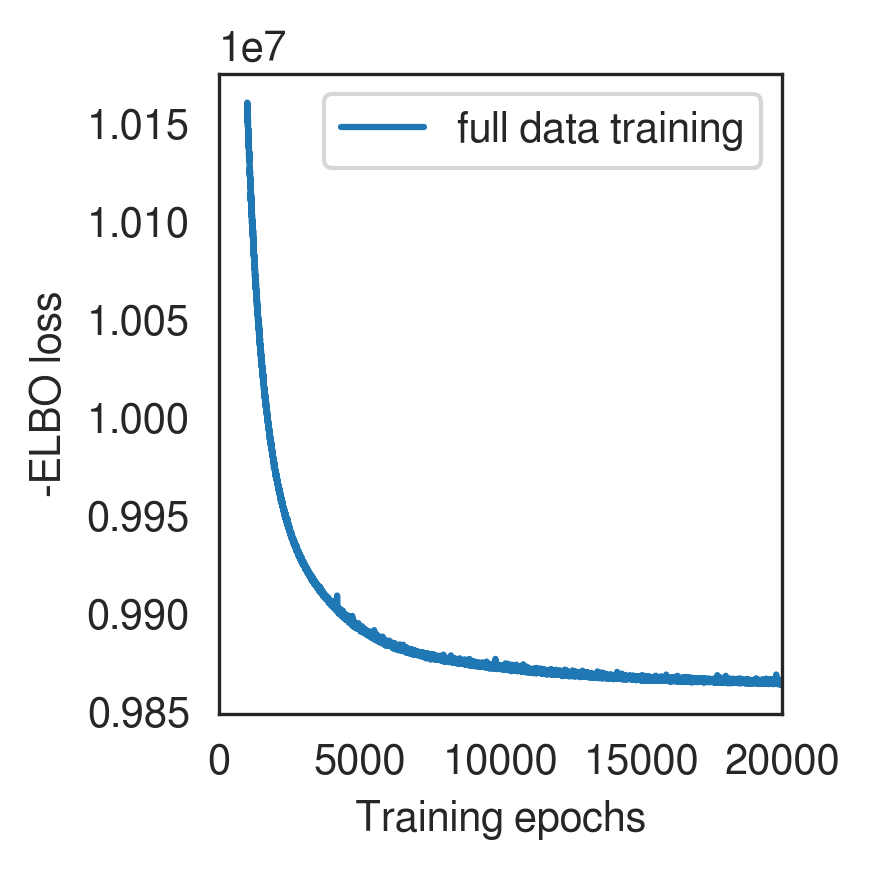

In [43]:
mod.train(max_epochs=10000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu=True,
         )

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training'])

Exporting estimated posterior distributions of cell abundance and saving results:

In [43]:
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
)

Sampling global variables, sample: 100%|█████████████████████████████████████████████████████████████████████████████| 999/999 [00:15<00:00, 65.86it/s]


In [52]:
# Convert density to proportions, calculate accuracy with GT & save results to output
density = adata_vis.obsm['q05_cell_abundance_w_sf']
proportions_cell2loc_df = density.div(density.sum(1), axis=0)
proportions_cell2loc_df.columns = [
    label.split('_w_sf_')[-1]
    for label in proportions_cell2loc_df.columns
]

proportions_cell2loc_df.head()

,Activated CD8,B cells memory,Basal,CAFs MSC iCAF-like,CAFs myCAF-like,Endothelial,PVL immature,Tcm,Treg,pDC
exper0_location_0,0.026931,0.073094,0.000789,0.717515,0.005628,0.000464,0.000595,0.164002,0.010398,0.000585
exper0_location_1,0.003866,0.043283,0.000631,0.651738,0.024730,0.000528,0.017607,0.000717,0.256782,0.000118
exper0_location_2,0.005220,0.003691,0.001443,0.899626,0.031601,0.001388,0.001910,0.041749,0.011557,0.001816
exper0_location_3,0.003112,0.000847,0.047072,0.795226,0.010570,0.000219,0.000588,0.013098,0.129038,0.000230
exper0_location_4,0.096685,0.004666,0.083791,0.640076,0.011752,0.000404,0.001046,0.008122,0.153097,0.000361


In [64]:
out_path = 'results/'
proportions_cell2loc_df.to_csv(
    os.path.join(out_path, 'Cell2Location_proportion_simu_10.csv'),
    index=True
)

Load previously saved proportions:

In [ ]:
# out_path = 'results/'
# proportions_cell2loc_df = pd.read_csv(os.path.join(out_path, 'Cell2Location_proportion_simu_10.csv'), index_col=[0])


Benchmark plots:

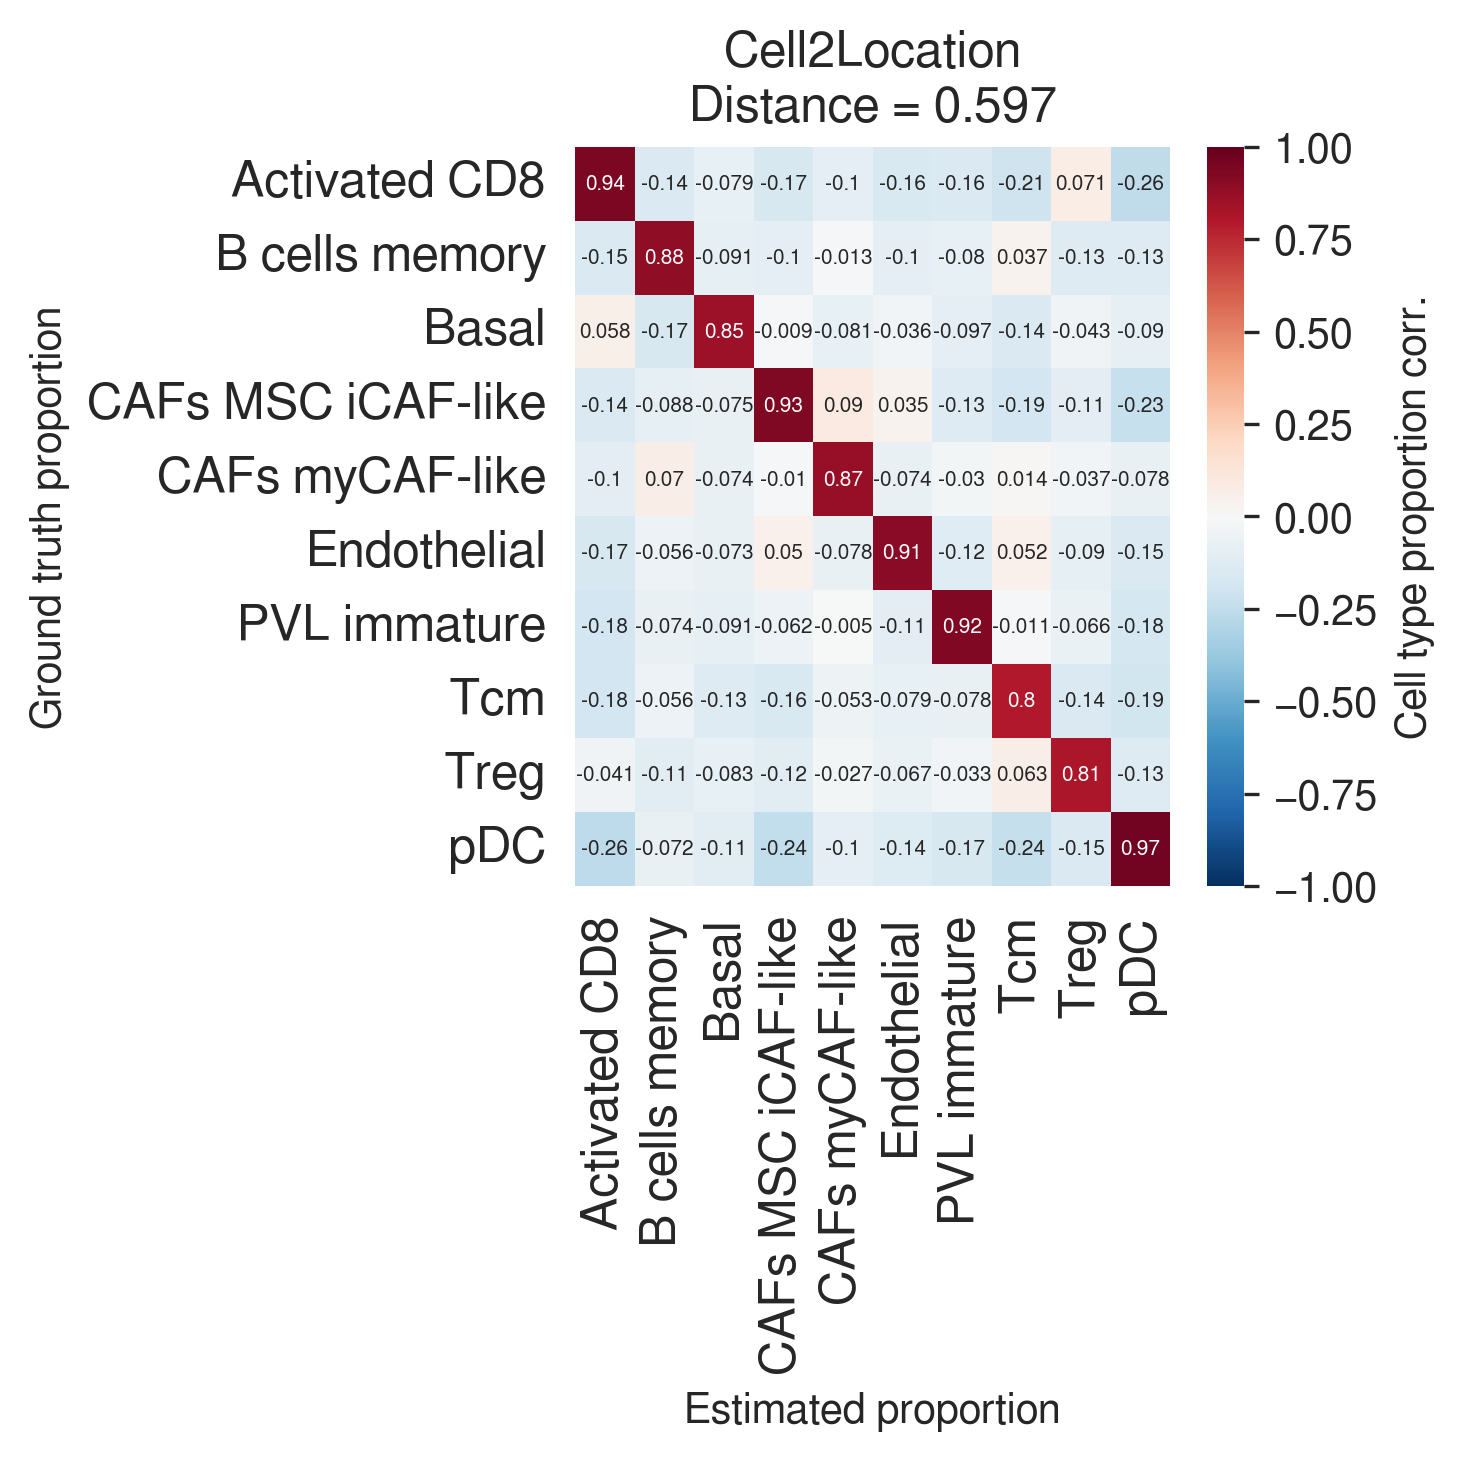

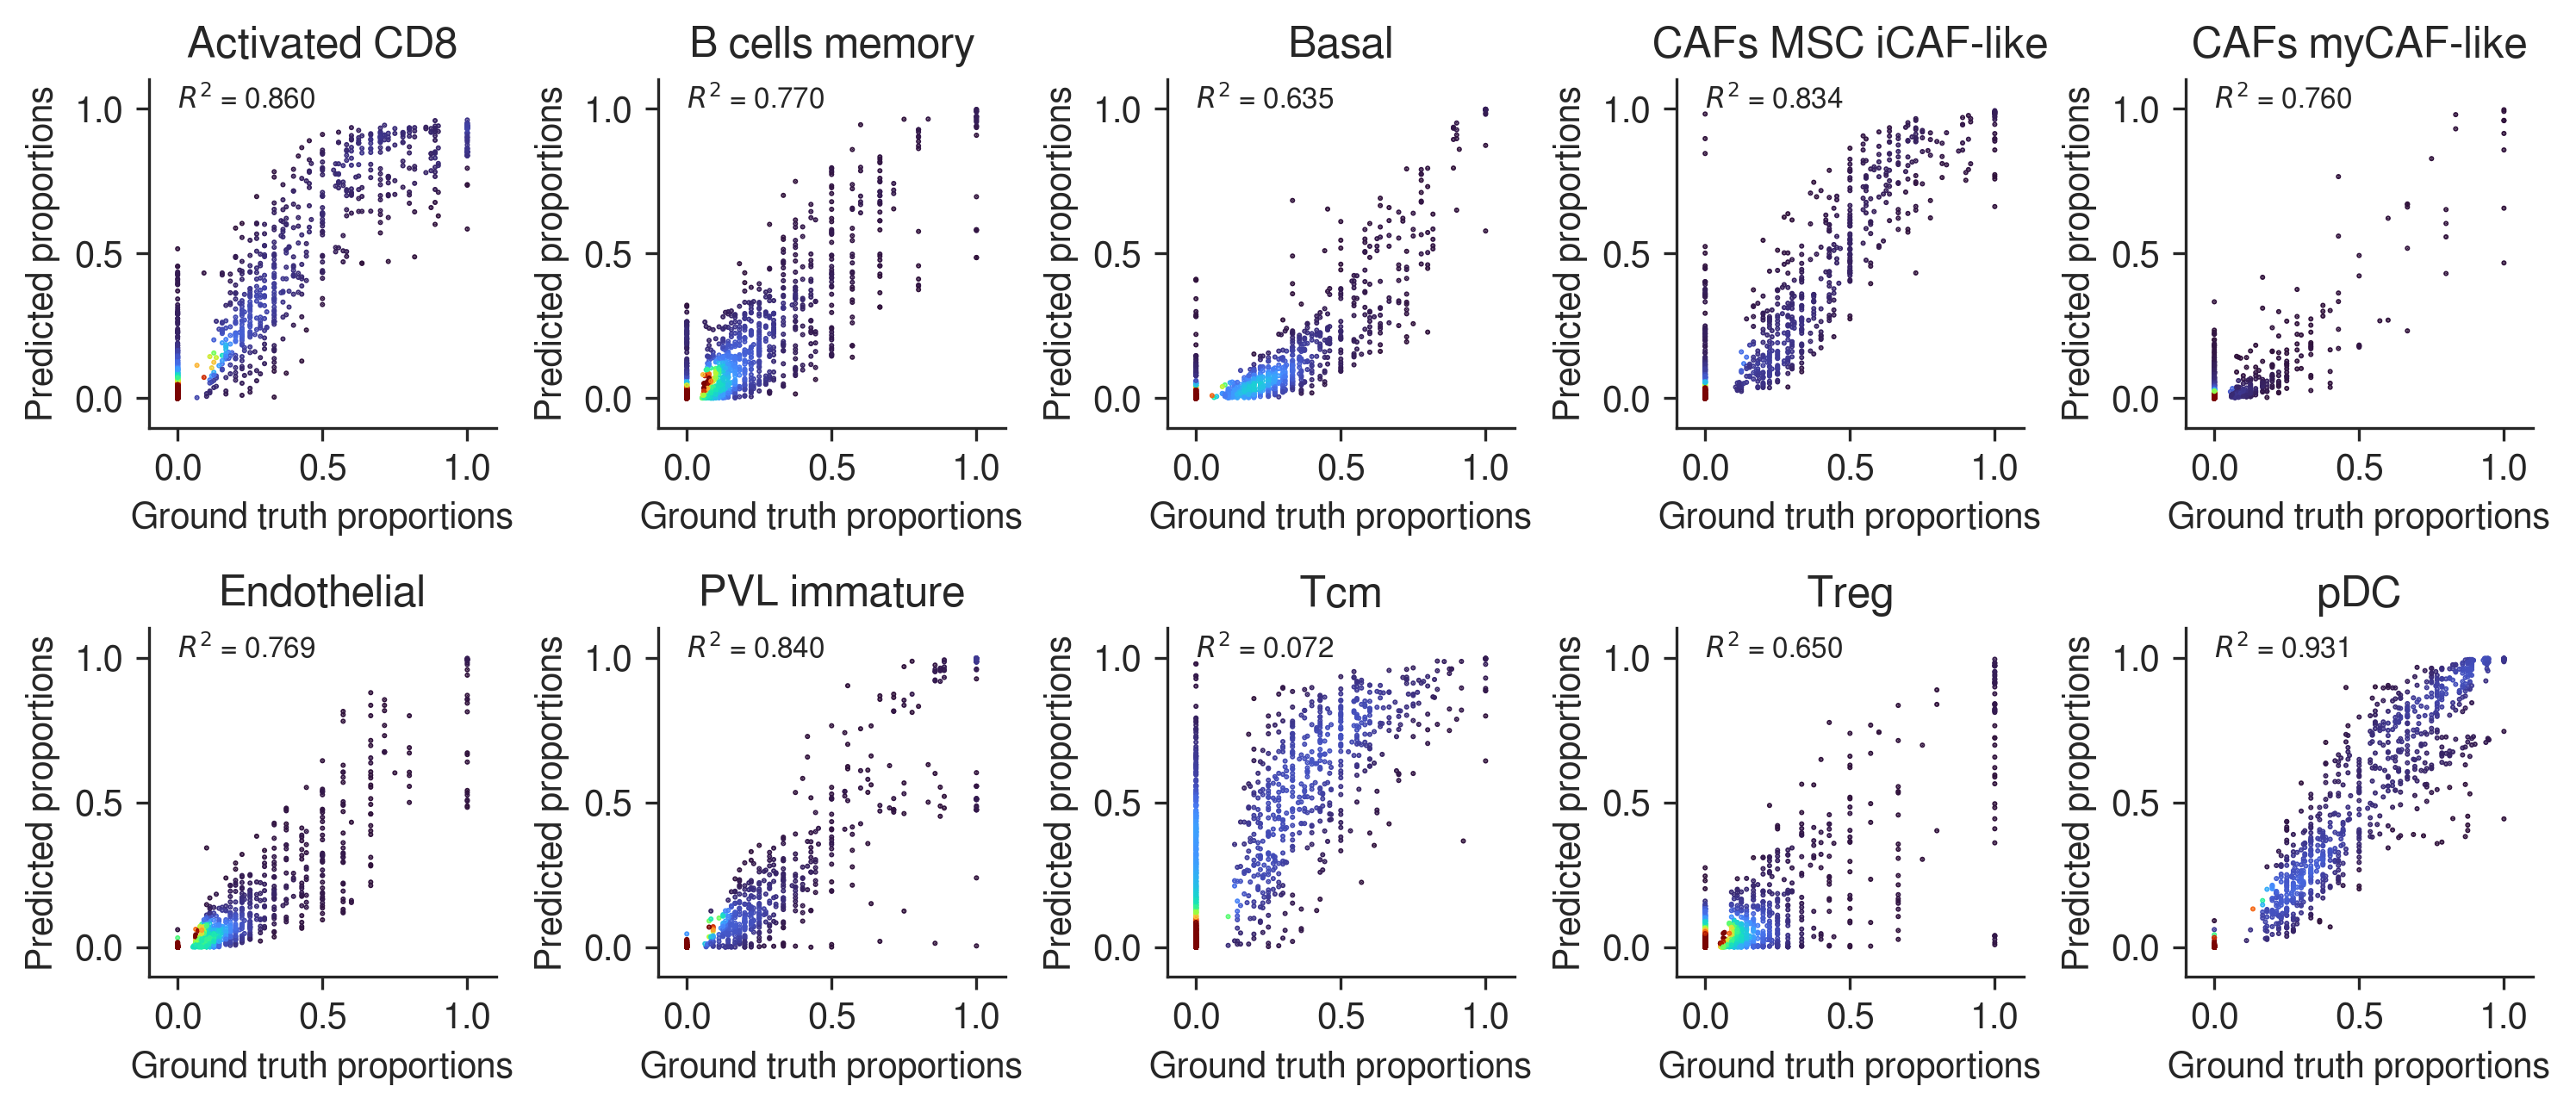

In [63]:
out_path = '../../plot_files/starfysh_revision/'

benchmark_utils.disp_corr(prop_df, proportions_cell2loc_df,
          fontsize=5,
          title='Cell2Location',
          outdir=out_path,
          filename='simu_10_cell2loc_heatmap',
          #savefig=True
)

benchmark_utils.disp_prop_scatter(prop_df, proportions_cell2loc_df,
      outdir=out_path,
      filename='simu_10_cell2loc_scatter',
      #savefig=True
)

### II. Real data

**Load ST data**

In [5]:
%ls ../../starfysh/data/

1142243F_TNBC/                  full_sigs.csv  P3A_MBC/   simulated_ST_data_1/
1160920F_TNBC/                  P1A_ER/        P3B_MBC/   tnbc_signature.csv
bc_signatures_version_1013.csv  P1B_ER/        P4A_MBC/
CID4465_TNBC/                   P2A_TNBC/      P4B_MBC/
CID44971_TNBC/                  P2B_TNBC/      README.md


In [6]:
%ls ../../starfysh/data/CID44971_TNBC/

CID44971_metadata.csv  CID44971_TNBC.h5ad  scrna/  scrna.tar.xz  spatial/


ST data:

In [27]:
# Load ST data
data_path = '../../starfysh/data/CID44971_TNBC/CID44971_TNBC.h5ad'


adata_vis = sc.read_h5ad(data_path)

# find mitochondria-encoded (MT) genes
adata_vis.var.index = adata_vis.var['features']
adata_vis.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_vis.var.index]

# remove MT genes for spatial mapping (keeping their counts in the object)
adata_vis.obsm['MT'] = adata_vis[:, adata_vis.var['MT_gene'].values].X.toarray()
adata_vis = adata_vis[:, ~adata_vis.var['MT_gene'].values]

In [10]:
# Get Cell2Location subset-level annotations
subset_annot_dict = {
    'Cancer Basal SC':                  'Basal',
    'Cancer LumB SC':                   'LumB',
    'Myoepithelial':                    'Normal epithelial',
    'T_cells_c0_CD4+_CCR7':             'Tcm',
    'T_cells_c1_CD4+_IL7R':             'Tem',
    'T_cells_c3_CD4+_Tfh_CXCL13':       'Tfh',
    'T_cells_c2_CD4+_T-regs_FOXP3':     'Treg',
    'T_cells_c7_CD8+_IFNG':             'Activated CD8',
    'T_cells_c8_CD8+_LAG3':             'Terminal exhaustion',
    'B cells Memory':                   'B cells memory',
    'B cells Naive':                    'B cells naive',
    'Myeloid_c10_Macrophage_1_EGR1':    'Macrophage M1',
    'Myeloid_c9_Macrophage_2_CXCL10':   'Macrophage M2',
    'Plasmablasts':                     'Plasmablasts',
    'Myeloid_c7_Monocyte_3_FCGR3A':     'Monocytes',
    'Myeloid_c12_Monocyte_1_IL1B':      'Monocytes',
    'Myeloid_c8_Monocyte_2_S100A9':     'Monocytes',
    'Myeloid_c11_cDC2_CD1C':            'cDC',
    'Myeloid_c3_cDC1_CLEC9A':           'cDC',
    'Myeloid_c4_DCs_pDC_IRF7':          'pDC',
    'CAFs MSC iCAF-like s1':            'CAFs MSC iCAF-like',
    'CAFs MSC iCAF-like s2':            'CAFs MSC iCAF-like',
    'CAFs myCAF like s4':               'CAFs myCAF-like',
    'CAFs myCAF like s5':               'CAFs myCAF-like',
    'PVL Immature s1':                  'PVL immature',
    'PVL_Immature s2':                  'PVL immature',
    'PVL Differentiated s3':            'PVL differentiated',
    'Endothelial ACKR1':                'Endothelial',
    'Endothelial CXCL12':               'Endothelial',
    'Endothelial Lymphatic LYVE1':      'Endothelial',
    'Endothelial RGS5':                 'Endothelial'
}

scRNA-seq data:

In [19]:
# Load paired scRNA-seq data
sc_path = '../../starfysh/data/CID44971_TNBC/scrna/'

barcode_df = pd.read_csv(
    os.path.join(sc_path, 'count_matrix_barcodes.tsv'), 
    delimiter='\t',
    header=None # this file doesn't contain the true "header" (column info), the first row is a TRUE barcode
)

gene_df = pd.read_csv(
    os.path.join(sc_path, 'count_matrix_genes.tsv'),
    delimiter='\t',
    header=None # this file doesn't contain the true "header" (column info), the first row is a TRUE gene
)

barcodes = pd.DataFrame(barcode_df[0].values, index=barcode_df[0].values, columns=['Barcode'])
genes = pd.DataFrame(gene_df[0].values, index=gene_df[0].values, columns=['features'])

cnt = mmread(
    os.path.join(sc_path, 'count_matrix_sparse.mtx')
).toarray()

adata_sc = sc.AnnData(
    X=cnt.T,
    obs=barcodes,
    var=genes
)

In [52]:
adata_sc.shape

(5858, 12342)

Load scRNA-seq cell type annotations from metadata

In [26]:
# Rename annotations & only keep scRNA-seq index with the existing cell types
meta_df = pd.read_csv(
    os.path.join(sc_path, 'metadata.csv'), index_col=[0], header=[0]
)

annots = meta_df['celltype_subset'].apply(lambda x: subset_annot_dict[x] if x in subset_annot_dict.keys() else np.nan)

cells_to_keep = annots.isin(subset_annot_dict.values())
adata_sc = adata_sc[cells_to_keep, :]
annots = annots[cells_to_keep]
adata_sc.obs['subset_cell_types'] = annots[cells_to_keep].tolist()

adata_sc

AnnData object with n_obs × n_vars = 5858 × 29733
    obs: 'Barcode', 'subset_cell_types'
    var: 'features'

In [ ]:
annot_lbl = 'celltype_subset'
meta_df[annot_lbl].value_counts()

T_cells_c0_CD4+_CCR7              1051
T_cells_c8_CD8+_LAG3               802
T_cells_c2_CD4+_T-regs_FOXP3       651
Cancer Basal SC                    646
Luminal Progenitors                442
T_cells_c4_CD8+_ZFP36              410
T_cells_c7_CD8+_IFNG               377
T_cells_c1_CD4+_IL7R               350
B cells Memory                     273
T_cells_c11_MKI67                  271
CAFs MSC iCAF-like s1              246
Cancer Cycling                     246
T_cells_c3_CD4+_Tfh_CXCL13         195
CAFs MSC iCAF-like s2              175
Mature Luminal                     169
Myeloid_c1_LAM1_FABP5              126
Myoepithelial                      124
T_cells_c6_IFIT1                   114
Endothelial ACKR1                  106
Myeloid_c2_LAM2_APOE               103
B cells Naive                       96
Myeloid_c12_Monocyte_1_IL1B         95
T_cells_c9_NK_cells_AREG            94
CAFs myCAF like s5                  94
Myeloid_c4_DCs_pDC_IRF7             72
Myeloid_c8_Monocyte_2_S10

**Running Cell2Location**

Filter low-quality genes:

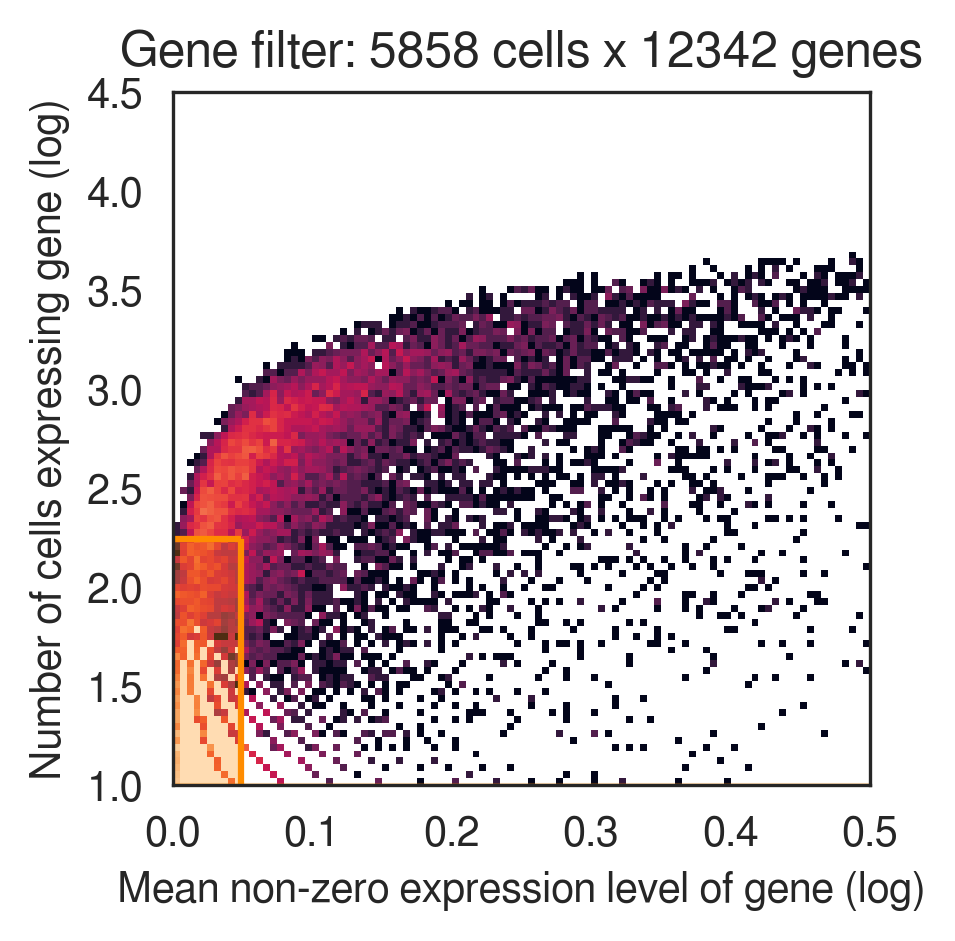

In [28]:
from cell2location.utils.filtering import filter_genes

selected = filter_genes(adata_sc, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

# filter the object
adata_sc = adata_sc[:, selected].copy()

**Estimation of reference cell type signatures**

In [29]:
# prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata=adata_sc, labels_key='subset_cell_types')

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [30]:
# create the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(adata_sc)

# view anndata_setup as a sanity check
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.20.3.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': None,
│   'labels_key': 'subset_cell_types',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 5858  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │  22   │
│          n_vars          │ 12342 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                            labels State Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃        Source Location         ┃     Categories      ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['subset_cell_types'] │    Activated CD8    │          0          │
│                                │   B cells memory    │          1          │
│                                │    B cells naive    │          2          │
│                                │        Basal        │          3          │
│                                │ CAFs MSC iCAF-like  │          4          │
│                                │   CAFs myCAF-like   │          5          │
│                                │     Endothelial     │          6          │
│                                │        LumB         │          7          │
│                                │    Macrophage M1    │          8          │
│                                │    Macrophage M2    │          9          │
│                                │      Monocytes      │         10          │
│                                │  Normal epithelial  │         11          │
│                                │ PVL differentiated  │         12          │
│                                │    PVL immature     │         13          │
│                                │    Plasmablasts     │         14          │
│                                │         Tcm         │         15          │
│                                │         Tem         │         16          │
│                                │ Terminal exhaustion │         17          │
│                                │         Tfh         │         18          │
│                                │        Treg         │         19          │
│                                │         cDC         │         20          │
│                                │         pDC         │         21          │
└────────────────────────────────┴─────────────────────┴─────────────────────┘

In [47]:
t0 = time.perf_counter()
mod.train(max_epochs=1000, use_gpu=True)
t1 = time.perf_counter()
runtime_sc = t1 - t0

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1000/1000: 100%|███████████████████████████████████████████████████████████████| 1000/1000 [01:01<00:00, 16.29it/s, v_num=1, elbo_train=9.86e+6]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 1000/1000: 100%|███████████████████████████████████████████████████████████████| 1000/1000 [01:01<00:00, 16.25it/s, v_num=1, elbo_train=9.86e+6]


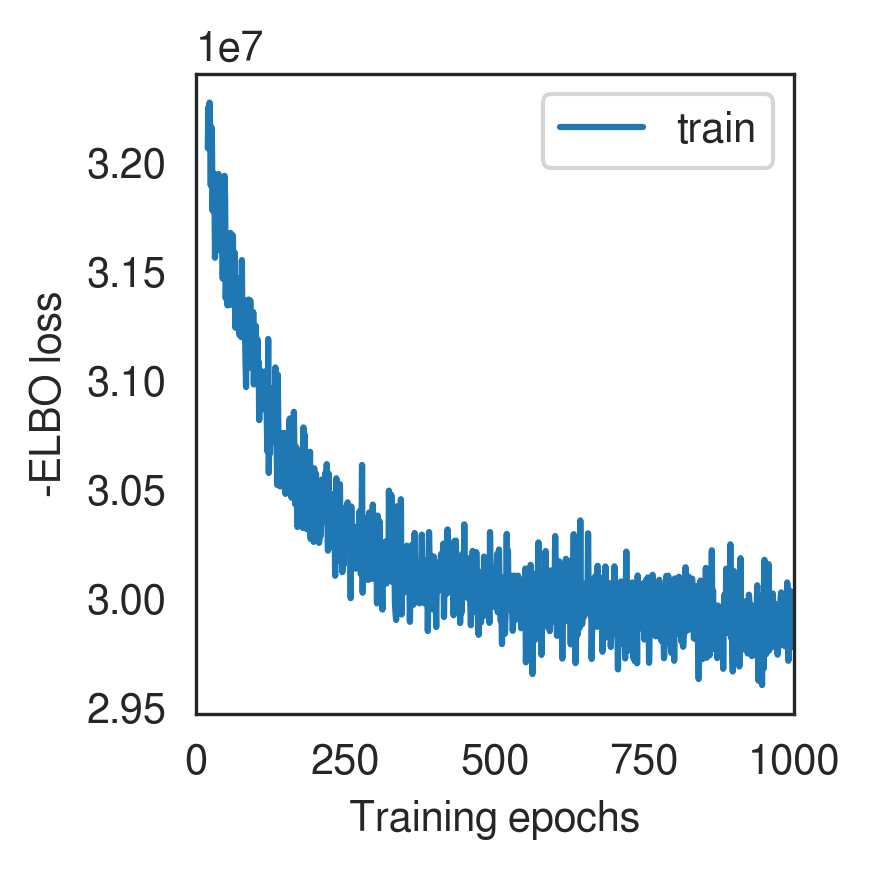

In [34]:
mod.plot_history(20)

Extracted estimated expression of signatures in each cell type:

In [35]:
# Sample posterior estimates
adata_sc = mod.export_posterior(
    adata_sc, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
)

# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_sc.varm.keys():
    inf_aver = adata_sc.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_sc.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_sc.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_sc.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_sc.uns['mod']['factor_names']
inf_aver.head()

Sampling global variables, sample: 100%|███████████████████████████████████████████████████████████████████████████| 999/999 [00:08<00:00, 118.00it/s]


,Activated CD8,B cells memory,B cells naive,Basal,CAFs MSC iCAF-like,CAFs myCAF-like,Endothelial,LumB,Macrophage M1,Macrophage M2,...,PVL differentiated,PVL immature,Plasmablasts,Tcm,Tem,Terminal exhaustion,Tfh,Treg,cDC,pDC
FO538757.2,0.087473,0.054315,0.076587,0.403496,0.109641,0.143293,0.122450,0.303436,0.281690,0.218783,...,0.031393,0.077688,0.158521,0.055236,0.040728,0.052279,0.049011,0.087986,0.527175,0.138539
NOC2L,0.174423,0.217538,0.237527,1.950149,0.236396,0.316522,0.291191,0.190302,0.334304,0.694254,...,0.460116,0.256480,0.231768,0.167099,0.132246,0.158364,0.245704,0.192500,0.421541,0.345704
HES4,0.007951,0.003962,0.025835,3.571579,0.130238,1.151199,0.312570,0.223008,0.289555,0.225438,...,2.243507,1.658115,0.108972,0.010948,0.015080,0.004089,0.029614,0.008859,0.090093,0.049150
ISG15,0.721226,0.810140,0.222672,0.769795,0.481605,3.166095,1.689855,0.238249,3.788166,10.129075,...,1.870832,1.782937,1.138685,0.385311,0.519341,0.852060,0.757125,1.172035,2.111035,1.935675
AGRN,0.011596,0.003921,0.011857,0.222492,0.041337,0.147179,0.340079,1.236800,0.097929,0.199236,...,0.276029,0.228192,0.023134,0.003182,0.003648,0.004508,0.012829,0.004289,0.070953,0.033104


**Cell2Location mapping & deconvolution**

In [36]:
# Subset shared genes between scRNA-seq ref & ST data
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis)


In [37]:
# Create & train the model
mod = cell2location.models.Cell2location(
    adata_vis, 
    cell_state_df=inf_aver,
     N_cells_per_location=10,
    detection_alpha=200
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 10000/10000: 100%|███████████████████████████████████████████████████████████| 10000/10000 [10:10<00:00, 16.29it/s, v_num=1, elbo_train=9.87e+6]

`Trainer.fit` stopped: `max_epochs=10000` reached.


Epoch 10000/10000: 100%|███████████████████████████████████████████████████████████| 10000/10000 [10:10<00:00, 16.37it/s, v_num=1, elbo_train=9.87e+6]


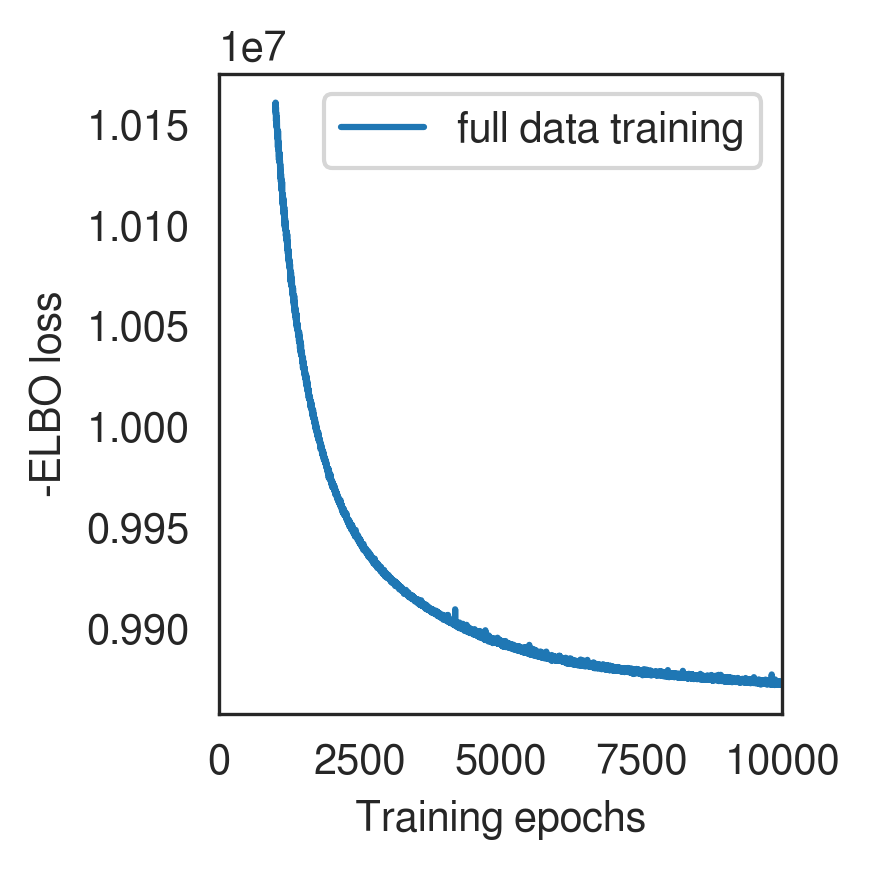

In [38]:
t0 = time.perf_counter()
mod.train(max_epochs=10000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu=True,
         )
t1 = time.perf_counter()
runtime_st = t1 - t0

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training'])

In [51]:
runtime = runtime_sc + runtime_st
print('Running time:', runtime, 'second', runtime/60, 'min')

Running time: 809.2172319050878 second 13.486953865084796 min


Exporting estimated posterior distributions of cell abundance and saving results:

In [39]:
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
)

Sampling global variables, sample: 100%|████████████████████████████████████████████████████████████████████████████| 999/999 [00:12<00:00, 82.98it/s]


In [40]:
# Convert density to proportions, calculate accuracy with GT & save results to output
density = adata_vis.obsm['q05_cell_abundance_w_sf']
proportions_cell2loc_df = density.div(density.sum(1), axis=0)
proportions_cell2loc_df.columns = [
    label.split('_w_sf_')[-1]
    for label in proportions_cell2loc_df.columns
]

proportions_cell2loc_df.head()

,Activated CD8,B cells memory,B cells naive,Basal,CAFs MSC iCAF-like,CAFs myCAF-like,Endothelial,LumB,Macrophage M1,Macrophage M2,...,PVL differentiated,PVL immature,Plasmablasts,Tcm,Tem,Terminal exhaustion,Tfh,Treg,cDC,pDC
AACATTGGTCAGCCGT-1,0.008862,0.019196,0.032162,0.067049,0.125316,0.011447,0.027718,0.013731,0.012186,0.005329,...,0.019457,0.004402,0.004446,0.136146,0.011057,0.009187,0.008415,0.011783,0.019486,0.006582
CATCGAATGGATCTCT-1,0.002078,0.064198,0.011367,0.060685,0.030115,0.001305,0.003105,0.001472,0.005658,0.002142,...,0.006612,0.002846,0.001109,0.362301,0.001915,0.001908,0.001287,0.001555,0.000843,0.004439
CGGGTTGTAGCTTTGG-1,0.000970,0.033156,0.020795,0.058839,0.034622,0.000245,0.014620,0.005680,0.004988,0.000742,...,0.003588,0.003155,0.000094,0.400144,0.001996,0.000783,0.000577,0.000742,0.001715,0.006634
CCTAAGTGTCTAACCG-1,0.005027,0.005560,0.008955,0.102798,0.059840,0.013135,0.006889,0.014343,0.006065,0.005812,...,0.010249,0.022232,0.000395,0.056258,0.005746,0.004210,0.005773,0.004710,0.003792,0.004120
TCTGTGACTGACCGTT-1,0.002318,0.025125,0.017316,0.060093,0.087018,0.000612,0.000727,0.010834,0.002337,0.000964,...,0.002556,0.006906,0.000049,0.241915,0.002800,0.001593,0.001672,0.001494,0.003788,0.009657


In [41]:
out_path = 'results/'
proportions_cell2loc_df.to_csv(
    os.path.join(out_path, 'Cell2Location_44971_proportion.csv'),
    index=True
)

---